In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

mnist_dataset = torchvision.datasets.MNIST(root='mnist_data', train=True, download=True, transform=transforms.ToTensor())


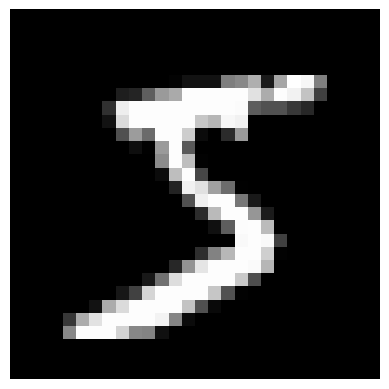

In [4]:
zt0 = mnist_dataset[0][0]

import matplotlib.pyplot as plt

plt.imshow(zt0.squeeze(0), cmap= 'gray')
plt.axis('off')
plt.show()

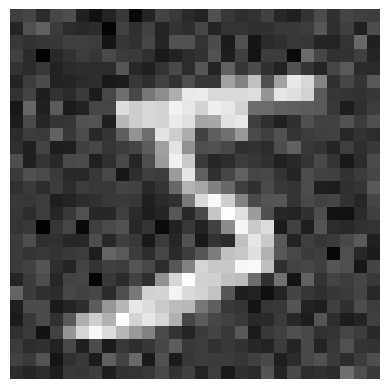

In [5]:

def noise_step(zt, beta_t):
    beta_t = torch.tensor(beta_t)
    distibution = torch.distributions.Normal(torch.sqrt(1- beta_t)*zt, beta_t*torch.ones_like(zt))
    zt = distibution.sample()
    return zt

zt = noise_step(zt0, 0.1)
plt.imshow(zt.squeeze(0), cmap= 'gray')
plt.axis('off')
plt.show()

In [6]:
import torch.nn as nn

class DDPM_beta_t_scheduler(nn.Module):
    def __init__(self, num_steps = 1000):
        super().__init__()
        self.beta_t = torch.linspace(1e-4, 0.02, num_steps, requires_grad=False)
        aplha_t = 1 - self.beta_t
        self.alpha_t = torch.cumprod(aplha_t, dim=0).requires_grad_(False)

    def call(self, t):
        return self.alpha_t[t], self.beta_t[t]
    
scheduler = DDPM_beta_t_scheduler()

scheduler.call(200)

(tensor(0.6563), tensor(0.0041))

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3060


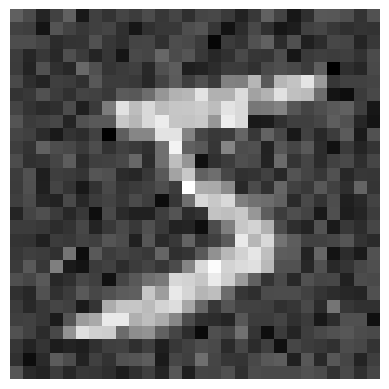

In [7]:
def difsuion_kernal(x, alpha_t):
    distribution = torch.distributions.Normal(torch.sqrt(1-alpha_t)*x, (1- alpha_t)*torch.ones_like(x))

    return distribution.sample()
# step 200

aplha_t, beta_t = scheduler.call(40)

zt200 = difsuion_kernal(zt0, aplha_t)

plt.imshow(zt200.squeeze(0), cmap= 'gray')
plt.axis('off')
plt.show()

770


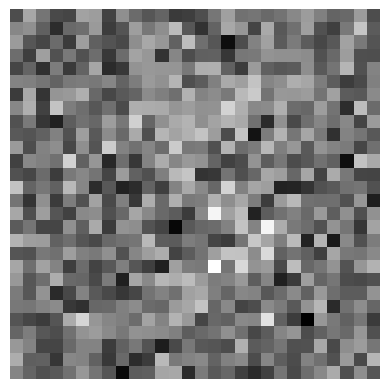

In [8]:
def sample_image(x):
    #choose random time step between 0 and 1000
    t = torch.randint(0, 1000, (1,)).item()
    alpha_t, beta_t = scheduler.call(t)
    zt = difsuion_kernal(x, alpha_t)
    print(t)
    return zt

zt = sample_image(zt0)
plt.imshow(zt.squeeze(0), cmap= 'gray')
plt.axis('off')
plt.show()

In [9]:
import math
embeding_size = 64

context_length = 100
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()

        pos = torch.arange(0, time_steps, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        self.embedings = torch.zeros(time_steps, embed_dim)
        self.embedings[:, 0::2] = torch.sin(pos * div)
        self.embedings[:, 1::2] = torch.cos(pos * div)

    def forward(self, t):
        return self.embedings[t]
#plot

Sinusoidal_embeding = SinusoidalEmbeddings(100, 64)

one_exmp = Sinusoidal_embeding(20)
print(one_exmp)

tensor([ 0.9129,  0.4081,  0.6519, -0.7583, -0.9686,  0.2486,  0.8365, -0.5480,
         0.0414,  0.9991, -0.9995,  0.0304, -0.4032, -0.9151,  0.4569, -0.8895,
         0.9093, -0.4161,  0.9975,  0.0709,  0.9021,  0.4315,  0.7469,  0.6649,
         0.5911,  0.8066,  0.4567,  0.8896,  0.3482,  0.9374,  0.2636,  0.9646,
         0.1987,  0.9801,  0.1494,  0.9888,  0.1122,  0.9937,  0.0842,  0.9964,
         0.0632,  0.9980,  0.0474,  0.9989,  0.0356,  0.9994,  0.0267,  0.9996,
         0.0200,  0.9998,  0.0150,  0.9999,  0.0112,  0.9999,  0.0084,  1.0000,
         0.0063,  1.0000,  0.0047,  1.0000,  0.0036,  1.0000,  0.0027,  1.0000])


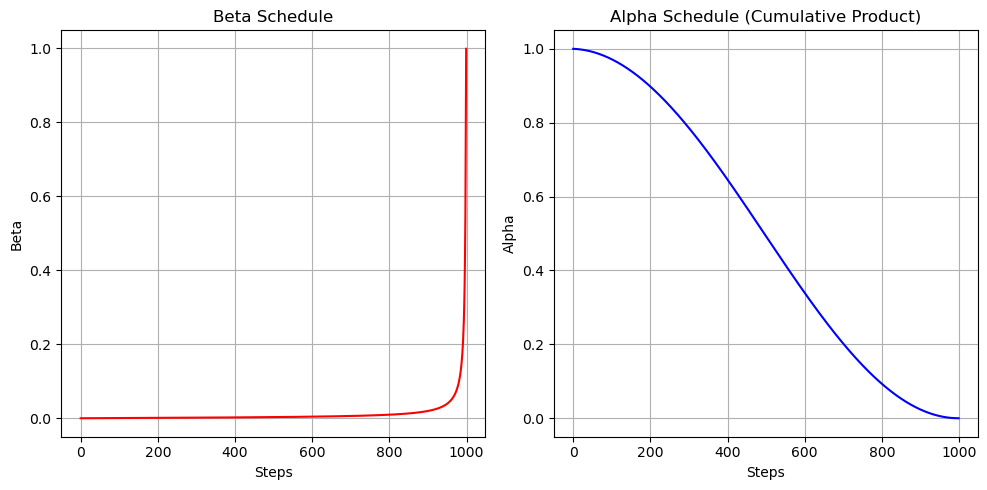

In [20]:
import numpy as np
class DDPM_beta_t_linear_scheduler(nn.Module):
    def __init__(self, num_steps = 1000, s = 0.008):
        super().__init__()
        self.T = num_steps
        self.s = s
        self.betas, self.alphas, self.alpha_cumprod = self.compute_betas_and_alphas()
    

    def compute_betas_and_alphas(self):
        
        t = np.arange(0, self.T + 1)
        
        # Compute the cumulative noise schedule (alpha_bar) using the cosine function
        alpha_bar = np.cos(((t / self.T + self.s) / (1 + self.s)) * np.pi / 2) ** 2
        
        # Compute betas: beta_t = 1 - (alpha_bar[t] / alpha_bar[t-1])
        betas = np.clip(1 - (alpha_bar[1:] / alpha_bar[:-1]), 0, 0.999)
        
        # Compute alphas: alpha_t = 1 - beta_t
        alphas = 1 - betas
        
        # Compute the cumulative product of alphas
        alpha_cumprod = np.cumprod(alphas)
        
        return betas, alphas, alpha_cumprod
    

num_steps = 1000
scheduler = DDPM_beta_t_linear_scheduler(num_steps=num_steps)

# Convert alpha_t and beta_t to numpy for plotting
alpha_values = scheduler.alpha_cumprod
beta_values = scheduler.betas

# Plot alpha_t and beta_t
plt.figure(figsize=(10, 5))

# Plot beta_t
plt.subplot(1, 2, 1)
plt.plot(beta_values, label='beta_t', color='red')
plt.title('Beta Schedule')
plt.xlabel('Steps')
plt.ylabel('Beta')
plt.grid(True)

# Plot alpha_t
plt.subplot(1, 2, 2)
plt.plot(alpha_values, label='alpha_t', color='blue')
plt.title('Alpha Schedule (Cumulative Product)')
plt.xlabel('Steps')
plt.ylabel('Alpha')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()